In [ ]:
!pip install torchmetrics
!pip install torchmetrics[image]
!pip install torch-fidelity
!pip install torchsummary

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 926.4/926.4 kB 49.0 MB/s eta 0:00:00


In [ ]:
import subprocess
subprocess.run(["pip", "install", "pytorch-fid"], check=True)
from pytorch_fid import fid_score

CompletedProcess(args=['pip', 'install', 'pytorch-fid'], returncode=0)

In [ ]:
import os
import numpy as np
import math
import matplotlib.pyplot as plt
import torchvision.transforms as transforms
from torchvision.utils import save_image
from torch.utils.data import DataLoader, random_split,Subset
from torchvision import datasets
from torch.autograd import Variable
import torch.nn as nn
import torch.nn.functional as F
import torch
from torchsummary import summary
from torchmetrics.image.fid import FrechetInceptionDistance

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
os.makedirs("images", exist_ok=True)
folder_path = "/content/drive/MyDrive/GAN_FashionMNIST"
if not os.path.exists(folder_path):
    os.makedirs(folder_path)

## Hyperparameter

In [ ]:
class Hyperparameter():
    def __init__(self,epochs=100,
                batch_size=64,
                lr=2e-4 ,
                b1=0.5,
                b2=0.999,
                latent_dim=100,
                img_size=28,
                channels=1):
      self.epochs=epochs
      self.batch_size=batch_size
      self.lr=lr
      self.b1=b1
      self.b2=b2
      self.latent_dim=latent_dim
      self.img_size=img_size
      self.channels=channels
opt = Hyperparameter()
img_shape = (opt.channels, opt.img_size, opt.img_size)
cuda = True if torch.cuda.is_available() else False

## data

In [ ]:
os.makedirs("../../data/GAN/FashionMNIST", exist_ok=True)

dataset = datasets.FashionMNIST("../../data/GAN/FashionMNIST",
                                 train=True, download=True,
                                 transform=transforms.Compose([transforms.ToTensor()]))

train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size
train_dataset, val_dataset = random_split(dataset, [train_size, val_size])
train_dataloader = DataLoader(train_dataset, batch_size=opt.batch_size, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=opt.batch_size, shuffle=False)

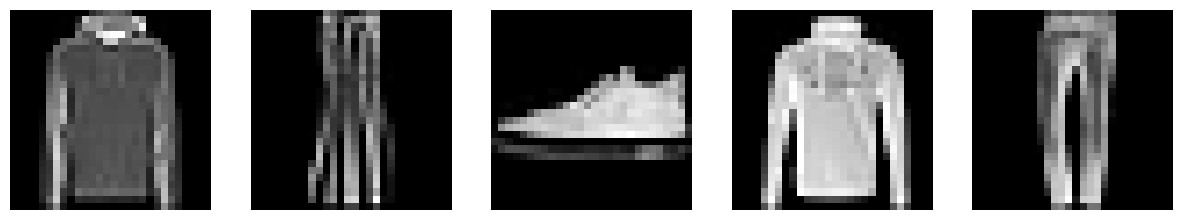

In [ ]:
for i, (imgs, _) in enumerate(train_dataloader):
    if i == 0:
        break
imgs = imgs.numpy()
fig, axes = plt.subplots(1, 5, figsize=(15, 5))
for ax, img in zip(axes, imgs[:5]):
    ax.imshow(np.transpose(img, (1, 2, 0)), cmap='gray')
    ax.axis('off')
plt.show()

## Generator

In [ ]:
class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()
        self.model = nn.Sequential(
            nn.ConvTranspose2d(opt.latent_dim, 128, kernel_size=7, stride=1, padding=0),#Layer 1: ConvTranspose2d
            nn.BatchNorm2d(128),    #Layer 2
            nn.ReLU(inplace=True),  #Layer 3
            nn.ConvTranspose2d(128, 64, kernel_size=4, stride=2, padding=1),#Layer 4: ConvTranspose2d
            nn.BatchNorm2d(64),     #Layer 5
            nn.ReLU(inplace=True),  #Layer 6
            nn.ConvTranspose2d(64, 1, kernel_size=4, stride=2, padding=1),#Layer 7: ConvTranspose2d
            nn.Sigmoid()            #Layer 8
        )
    def forward(self, z):
        img = self.model(z)
        return img


## Discriminator

In [ ]:
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()

        self.model = nn.Sequential(
            nn.Conv2d(1, 64, kernel_size=4, stride=2, padding=1),#Layer 1
            nn.LeakyReLU(0.2, inplace=True), #Layer 2
            nn.Conv2d(64, 128, kernel_size=4, stride=2, padding=1),#Layer 3
            nn.BatchNorm2d(128),     #Layer 4
            nn.LeakyReLU(0.2, inplace=True),#Layer 5
            nn.Conv2d(128, 256, kernel_size=4, stride=2, padding=1),#Layer 6
            nn.BatchNorm2d(256),     #Layer  7
            nn.LeakyReLU(0.2, inplace=True),#Layer 8
            nn.Conv2d(256,512, kernel_size=3, stride=1, padding=0),#Layer 9
            nn.BatchNorm2d(512),     #Layer 10
            nn.LeakyReLU(0.2, inplace=True),#Layer 11
            nn.Flatten(),#Layer 12
            nn.Linear(512, 1),#Layer 13
            nn.Sigmoid(),
        )

    def forward(self, img):
#        img_flat = img.view(img.size(0), -1)
 #       validity = self.model(img_flat)
        return self.model(img)

## Train

In [ ]:
adversarial_loss = torch.nn.BCELoss()
generator = Generator()
discriminator = Discriminator()
if cuda:
    generator.cuda()
    discriminator.cuda()
    adversarial_loss.cuda()

## Model summary

In [ ]:
summary(generator, (100, 1, 1))
summary(discriminator,(1,28,28))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
   ConvTranspose2d-1            [-1, 128, 7, 7]         627,328
       BatchNorm2d-2            [-1, 128, 7, 7]             256
              ReLU-3            [-1, 128, 7, 7]               0
   ConvTranspose2d-4           [-1, 64, 14, 14]         131,136
       BatchNorm2d-5           [-1, 64, 14, 14]             128
              ReLU-6           [-1, 64, 14, 14]               0
   ConvTranspose2d-7            [-1, 1, 28, 28]           1,025
           Sigmoid-8            [-1, 1, 28, 28]               0
Total params: 759,873
Trainable params: 759,873
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.44
Params size (MB): 2.90
Estimated Total Size (MB): 3.34
----------------------------------------------------------------
------------------------------------------

## LOOP

In [ ]:
optimizer_G = torch.optim.Adam(generator.parameters(), lr=opt.lr, betas=(opt.b1, opt.b2))
optimizer_D = torch.optim.Adam(discriminator.parameters(), lr=0.00001, betas=(opt.b1, opt.b2))
Tensor = torch.cuda.FloatTensor if cuda else torch.FloatTensor

In [ ]:
g_train_loss,d_train_loss, g_val_loss_list,d_val_loss_list=[],[],[],[]
val_FID=[]
opt.epochs=60
for epoch in range(opt.epochs):
    g_epoch_loss = 0.0
    d_epoch_loss = 0.0
    for i, (imgs, _) in enumerate(train_dataloader):
        imgs = imgs.to(device)
        valid = torch.full((imgs.size(0), 1), 0.95, device=imgs.device, requires_grad=False)
        fake = torch.full((imgs.size(0), 1), 0.05, device=imgs.device, requires_grad=False)
        real_imgs = imgs.to(device)

        #  Train Generator
        optimizer_G.zero_grad()
        z = torch.randn(imgs.size(0), opt.latent_dim, 1, 1, device=imgs.device)
        gen_imgs = generator(z)
        g_loss = adversarial_loss(discriminator(gen_imgs), valid)
        g_loss.backward()
        optimizer_G.step()

        #  Train Discriminator
        optimizer_D.zero_grad()
        real_loss = adversarial_loss(discriminator(real_imgs), valid)
        fake_loss = adversarial_loss(discriminator(gen_imgs.detach()), fake)
        d_loss = (real_loss + fake_loss) / 2
        d_loss.backward()
        optimizer_D.step()
        g_epoch_loss += g_loss.item()
        d_epoch_loss += d_loss.item()

        if i % 250 == 0:
            print("[Epoch %d/%d] [Batch %d/%d] [D loss: %f] [G loss: %f]"
            % (epoch, opt.epochs, i, len(train_dataloader), d_loss.item(), g_loss.item()))

    g_train_loss.append(g_epoch_loss / len(train_dataloader))
    d_train_loss.append(d_epoch_loss / len(train_dataloader))

    if epoch %5 ==0:
        image_save_path = os.path.join(folder_path, f"NEW-image-epoch {epoch}.png")
        save_image(gen_imgs.data[:25], image_save_path, nrow=5, normalize=True)
        generator_save_path  = os.path.join(folder_path, f"NEW-model_generator-epoch {epoch}.pth")
        torch.save(generator.state_dict(), generator_save_path)

    #Validation Mode
    generator.eval()
    discriminator.eval()
    with torch.no_grad():
        g_val_loss = 0.0
        d_val_loss = 0.0
        val_batches = 0

        for val_imgs, _ in val_dataloader:
            val_imgs = val_imgs.to(device)
            valid = torch.ones(val_imgs.size(0), 1, device=val_imgs.device, requires_grad=False)
            fake = torch.zeros(val_imgs.size(0), 1, device=val_imgs.device, requires_grad=False)

            z = torch.randn(val_imgs.size(0), opt.latent_dim, 1, 1, device=val_imgs.device)
            gen_val_imgs = generator(z)
            g_val_loss += adversarial_loss(discriminator(gen_val_imgs), valid).item()

            real_loss = adversarial_loss(discriminator(val_imgs), valid)
            fake_loss = adversarial_loss(discriminator(gen_val_imgs), fake)
            d_val_loss += ((real_loss + fake_loss) / 2).item()

            val_batches += 1

        g_val_loss /= val_batches
        d_val_loss /= val_batches
        g_val_loss_list.append(g_val_loss)
        d_val_loss_list.append(d_val_loss)
        if False:
            FID_=calculate_fid(generator, val_dataloader)
            val_FID.append(FID_)
            print(
            "[Validation]   [Epoch %d/%d]   [D val loss: %f]   [G val loss: %f]  [FID val : %f]"
            % (epoch, opt.epochs, d_val_loss, g_val_loss,FID_))
        else:
          print(
            "[Validation]   [Epoch %d/%d]   [D val loss: %f]   [G val loss: %f] "
            % (epoch, opt.epochs, d_val_loss, g_val_loss)
        )
        print('-----------------------------------------------------------')

[Epoch 0/60] [Batch 0/750] [D loss: 0.709812] [G loss: 0.715490]
[Epoch 0/60] [Batch 250/750] [D loss: 0.647684] [G loss: 0.748585]
[Epoch 0/60] [Batch 500/750] [D loss: 0.607628] [G loss: 0.804321]
[Validation]   [Epoch 0/60]   [D val loss: 0.950358]   [G val loss: 0.677514] 
-----------------------------------------------------------
[Epoch 1/60] [Batch 0/750] [D loss: 0.911994] [G loss: 0.679837]
[Epoch 1/60] [Batch 250/750] [D loss: 0.199770] [G loss: 2.854699]
[Epoch 1/60] [Batch 500/750] [D loss: 0.256894] [G loss: 2.229657]
[Validation]   [Epoch 1/60]   [D val loss: 0.069616]   [G val loss: 2.739198] 
-----------------------------------------------------------
[Epoch 2/60] [Batch 0/750] [D loss: 0.209278] [G loss: 2.602182]
[Epoch 2/60] [Batch 250/750] [D loss: 0.516391] [G loss: 1.050325]
[Epoch 2/60] [Batch 500/750] [D loss: 0.504653] [G loss: 1.167313]
[Validation]   [Epoch 2/60]   [D val loss: 0.577950]   [G val loss: 0.747466] 
----------------------------------------------

In [ ]:
image_save_path = os.path.join(folder_path, f"NEW-image-epoch {epoch}.png")
save_image(gen_imgs.data[:25], image_save_path, nrow=5, normalize=True)
generator_save_path  = os.path.join(folder_path, f"NEW-model_generator-epoch {epoch}.pth")
torch.save(generator.state_dict(), generator_save_path)

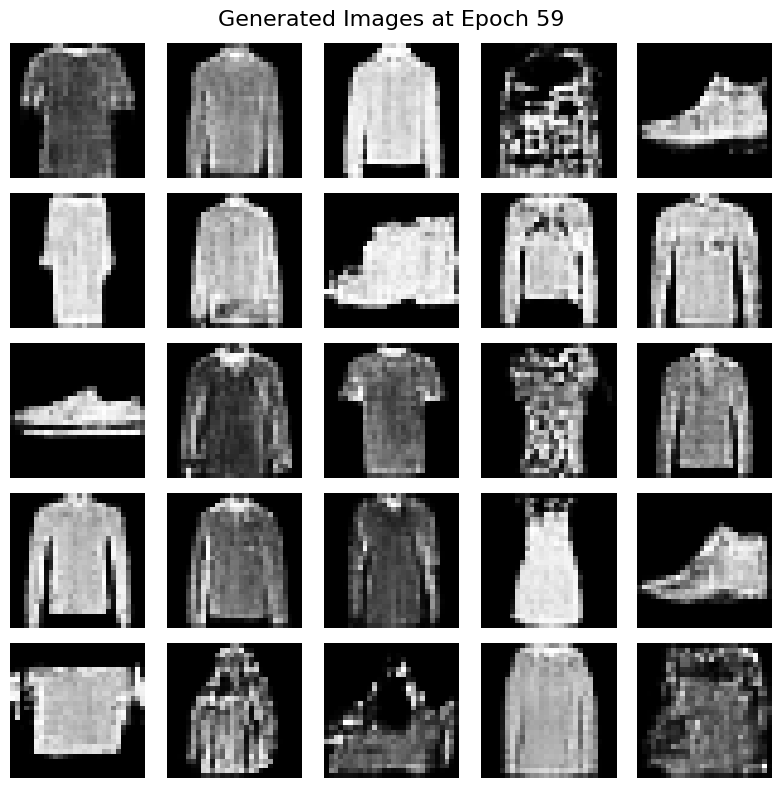

In [ ]:
def plot_generated_images(images, epoch):
    plt.figure(figsize=(8, 8))
    for i in range(min(25, images.size(0))):
        plt.subplot(5, 5, i + 1)
        plt.imshow(images[i].permute(1, 2, 0).detach().cpu().numpy(), aspect='equal',cmap='gray')
        plt.axis('off')

    plt.suptitle(f'Generated Images at Epoch {epoch}', fontsize=16)
    plt.tight_layout()
    plt.show()
plot_generated_images(gen_imgs.data[:25], epoch)

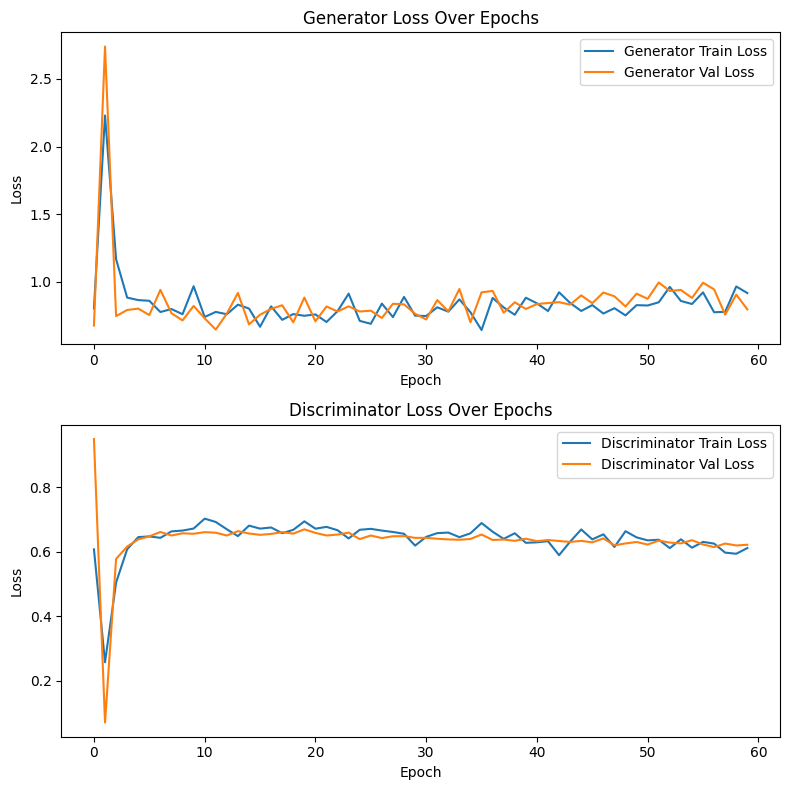

In [10]:
fig, axs = plt.subplots(2, 1, figsize=(8,8))
axs[0].plot(range(len(g_train_loss)), g_train_loss, label='Generator Train Loss')
axs[0].plot(range(len(g_val_loss_list)), g_val_loss_list, label='Generator Val Loss')
axs[0].set_xlabel("Epoch")
axs[0].set_ylabel("Loss")
axs[0].set_title("Generator Loss Over Epochs")
axs[0].legend()

axs[1].plot(range(len(d_train_loss)), d_train_loss, label='Discriminator Train Loss')
axs[1].plot(range(len(d_val_loss_list)), d_val_loss_list, label='Discriminator Val Loss')
axs[1].set_xlabel("Epoch")
axs[1].set_ylabel("Loss")
axs[1].set_title("Discriminator Loss Over Epochs")
axs[1].legend()

plt.tight_layout()
plt.show()

## Report of bad models

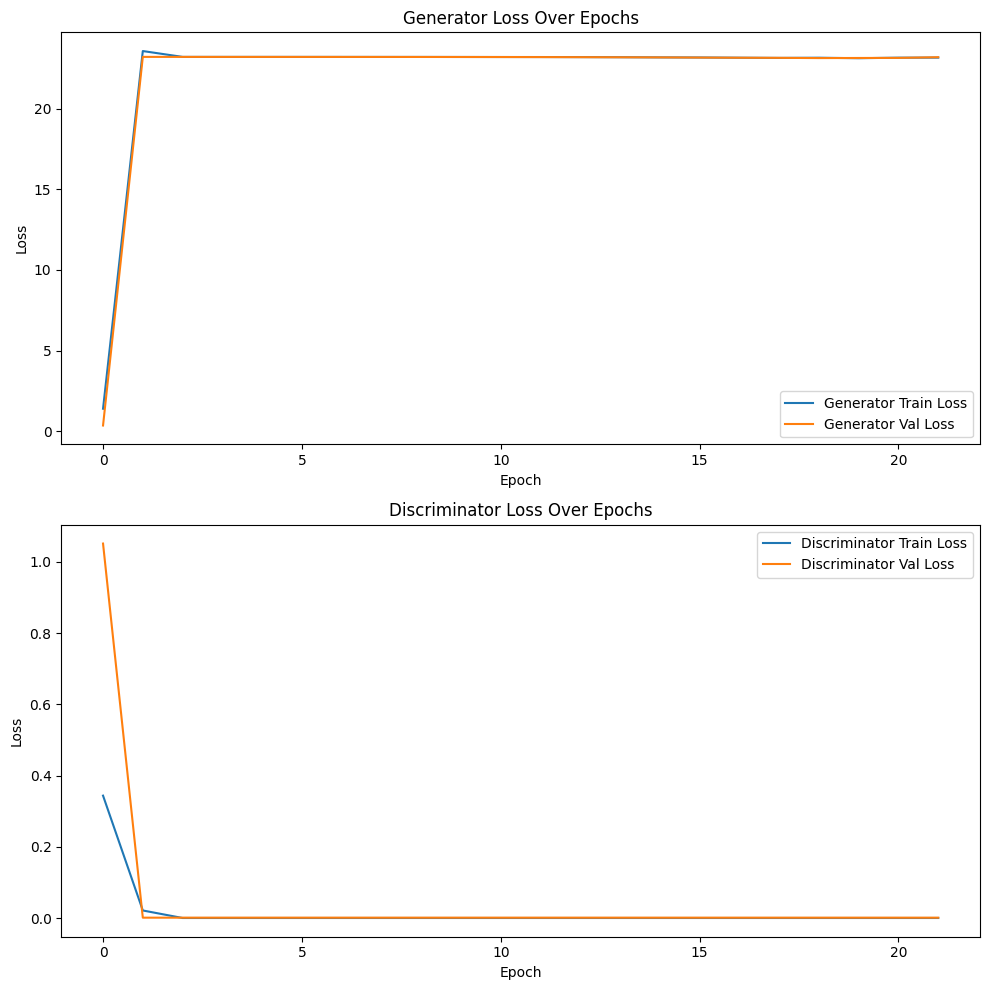

In [ ]:
fig, axs = plt.subplots(2, 1, figsize=(10, 10))
axs[0].plot(range(len(g_train_loss)), g_train_loss, label='Generator Train Loss')
axs[0].plot(range(len(g_val_loss_list)), g_val_loss_list, label='Generator Val Loss')
axs[0].set_xlabel("Epoch")
axs[0].set_ylabel("Loss")
axs[0].set_title("Generator Loss Over Epochs")
axs[0].legend()

axs[1].plot(range(len(d_train_loss)), d_train_loss, label='Discriminator Train Loss')
axs[1].plot(range(len(d_val_loss_list)), d_val_loss_list, label='Discriminator Val Loss')
axs[1].set_xlabel("Epoch")
axs[1].set_ylabel("Loss")
axs[1].set_title("Discriminator Loss Over Epochs")
axs[1].legend()

plt.tight_layout()
plt.show()

## FID Q6

In [ ]:
def generate_images_in_batches(generator, num_images, batch_size, save_path):
    os.makedirs(save_path, exist_ok=True)
    generator.eval()
    with torch.no_grad():
        for batch_start in range(0, num_images, batch_size):
            batch_end = min(batch_start + batch_size, num_images)
            batch_size_actual = batch_end - batch_start

            z = torch.randn(batch_size_actual, 100,1,1).to(next(generator.parameters()).device)
            fake_imgs = generator(z)
            fake_imgs = fake_imgs.squeeze()
            for i in range(batch_size_actual):
                fake_img = fake_imgs[i].cpu()
                fake_img_rgb = torch.cat([fake_img.unsqueeze(0)] * 3, dim=0)
                save_image(fake_img_rgb, os.path.join(save_path, f"fake_{batch_start + i}.png"))

In [ ]:
from pytorch_fid import fid_score


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

paths = {
    "early": "./generated_images_early",
    "epoch10": "./generated_images_epoch10",
    "epoch30": "./generated_images_epoch30",
    "epoch45": "./generated_images_epoch45",
    "epoch59": "./generated_images_epoch59", }

generator_early = Generator().to(device)
generator_epoch10 = Generator().to(device)
generator_epoch30 = Generator().to(device)
generator_epoch45= Generator().to(device)
generator_epoch59= Generator().to(device)



generator_early.load_state_dict(torch.load("/content/drive/MyDrive/GAN_FashionMNIST/NEW-model_generator-epoch 0.pth"))
generator_epoch10.load_state_dict(torch.load("/content/drive/MyDrive/GAN_FashionMNIST/NEW-model_generator-epoch 10.pth"))
generator_epoch30.load_state_dict(torch.load("/content/drive/MyDrive/GAN_FashionMNIST/NEW-model_generator-epoch 30.pth"))
generator_epoch45.load_state_dict(torch.load("/content/drive/MyDrive/GAN_FashionMNIST/NEW-model_generator-epoch 45.pth"))
generator_epoch59.load_state_dict(torch.load("/content/drive/MyDrive/GAN_FashionMNIST/NEW-model_generator-epoch 59.pth"))

batch_size = 100
generate_images_in_batches(generator_early, 5000, batch_size, paths["early"])
generate_images_in_batches(generator_epoch10, 5000, batch_size, paths["epoch10"])
generate_images_in_batches(generator_epoch30, 5000, batch_size, paths["epoch30"])
generate_images_in_batches(generator_epoch45, 5000, batch_size, paths["epoch45"])
generate_images_in_batches(generator_epoch59, 5000, batch_size, paths["epoch59"])

real_images_path = "./fashion_mnist_test"
os.makedirs(real_images_path, exist_ok=True)

test_dataset = datasets.FashionMNIST(root="./data", train=False, transform=transforms.Compose([transforms.Resize((28, 28)),transforms.ToTensor(),]), download=True,)

real_batch_size = 100
with torch.no_grad():
    for batch_start in range(0, 5000, real_batch_size):
        batch_end = min(batch_start + real_batch_size, 5000)
        real_batch = test_dataset.data[batch_start:batch_end].unsqueeze(1) / 255.0
        for i in range(real_batch.size(0)):
            real_img = real_batch[i]
            real_img_rgb = torch.cat([real_img] * 3, dim=0)
            save_image(real_img_rgb, os.path.join(real_images_path, f"real_{batch_start + i}.png"))

fid_scores = {}
for name, path in paths.items():
    fid = fid_score.calculate_fid_given_paths([real_images_path, path], batch_size=batch_size, device=device, dims=2048)
    fid_scores[name] = fid
    print(f"FID for {name}: {fid}")

print("FID Scores:", fid_scores)


<ipython-input-80-6b34315f3803>:21: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  generator_early.load_state_dict(torch.load("/content/drive/MyDrive/GAN_FashionMNIST/NEW-mod

FID for early: 388.04848880077475


100%|██████████| 50/50 [00:19<00:00,  2.60it/s]


FID for epoch10: 80.41811093810813


100%|██████████| 50/50 [00:19<00:00,  2.59it/s]


FID for epoch30: 62.77405155839085


100%|██████████| 50/50 [00:19<00:00,  2.59it/s]


FID for epoch45: 51.467099192720866


100%|██████████| 50/50 [00:19<00:00,  2.58it/s]


FID for epoch59: 48.7883308198152
FID Scores: {'early': 388.04848880077475, 'epoch10': 80.41811093810813, 'epoch30': 62.77405155839085, 'epoch45': 51.467099192720866, 'epoch59': 48.7883308198152}


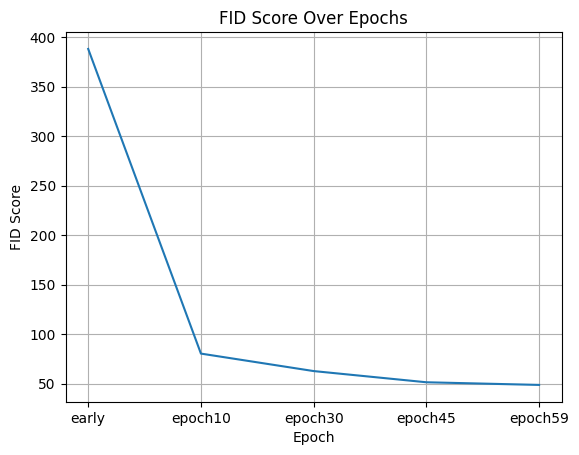

In [1]:
import matplotlib.pyplot as plt

fid_scores = {
    'early': 388.04848880077475,
    'epoch10': 80.41811093810813,
    'epoch30': 62.77405155839085,
    'epoch45': 51.467099192720866,
    'epoch59': 48.7883308198152
}
epochs = list(fid_scores.keys())
scores = list(fid_scores.values())

plt.plot(epochs, scores)
plt.xlabel('Epoch')
plt.ylabel('FID Score')
plt.title('FID Score Over Epochs')
plt.grid(True)
plt.show()